"""
Generate data with specified changepoints
Compare ELBO fits for changepoint model with different
numbers of changepoints
"""

In [69]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
from theano.tensor.extra_ops import cumsum
import sys
sys.path.append('/media/bigdata/firing_space_plot/ephys_data')
from ephys_data import ephys_data
import visualize

In [70]:
# Some poisson spiking
length = 1000
bin_width = 10
states = 2
nrns = 10
tastes = 4
trials = 20
fit = int(1e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random((tastes,trials,states)),axis=-1)
true_tau /= np.max(true_tau,axis=-1)[...,np.newaxis]
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)

print(true_tau.shape)

(4, 20, 2)


In [71]:
state_inds = np.concatenate([np.zeros((tastes,trials,1)),true_tau],axis=-1)
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:,:-1]

print(true_tau.shape)
print(state_inds.shape)

(4, 19, 2)
(4, 20, 3)


In [72]:
true_lambda = np.random.random((tastes,nrns,states))
print(true_lambda.shape)

(4, 10, 2)


In [73]:
true_r = np.zeros((tastes,trials, nrns, length))

for taste in range(tastes):
    for trial_num in range(trials):
        for state_num in range(states):
            true_r[taste,trial_num,:,state_inds[taste,trial_num,state_num]:state_inds[taste,trial_num,state_num+1]] = \
                            true_lambda[taste,:,state_num][:,np.newaxis]
        
data_array = np.random.random(true_r.shape) < true_r        


In [74]:
print(data_array.shape)
true_r_long = np.reshape(true_r, (-1,*true_r.shape[2:]))
data_array_long = np.reshape(data_array, (-1,*data_array.shape[2:]))
print(data_array_long.shape)
taste_labels = np.repeat(np.arange(tastes),trials)

(4, 20, 10, 1000)
(80, 10, 1000)


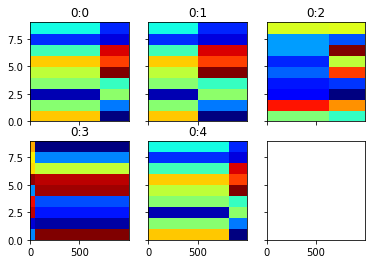

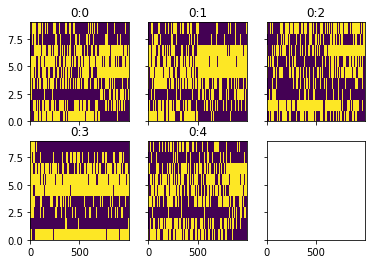

In [75]:
trial_count = 5
trial_inds = np.random.choice(np.arange(trials*tastes),5)
visualize.firing_overview(true_r_long[trial_inds]);
visualize.firing_overview(data_array_long[trial_inds], cmap='viridis');

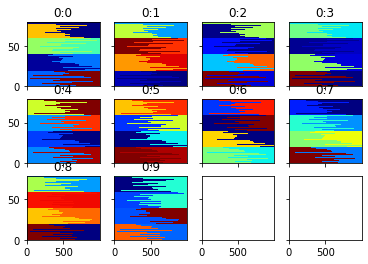

In [76]:
visualize.firing_overview(true_r_long.swapaxes(0,1));

In [77]:
spike_array = np.sum(data_array.reshape((*data_array.shape[:3],-1,bin_width)),axis=-1)
spike_array.shape

(4, 20, 10, 100)

In [78]:
spike_array_long = np.concatenate(spike_array, axis=0) 

# Find mean firing for initial values
tastes = spike_array.shape[0]
split_list = np.array_split(spike_array,states,axis=-1)
# Cut all to the same size
min_val = min([x.shape[-1] for x in split_list])
split_array = np.array([x[...,:min_val] for x in split_list])
mean_vals = np.mean(split_array,axis=(2,-1)).swapaxes(0,1)
mean_vals += 0.01 # To avoid zero starting prob
mean_nrn_vals = np.mean(mean_vals,axis=(0,1))

# Find evenly spaces switchpoints for initial values
idx = np.arange(spike_array.shape[-1]) # Index
array_idx = np.broadcast_to(idx, spike_array_long.shape)
idx_range = idx.max() - idx.min()
even_switches = np.linspace(0,idx.max(),states+1)
even_switches_normal = even_switches/np.max(even_switches)

taste_label = np.repeat(np.arange(spike_array.shape[0]), spike_array.shape[1])
trial_num = array_idx.shape[0]


In [79]:
mean_vals.shape

(4, 2, 10)

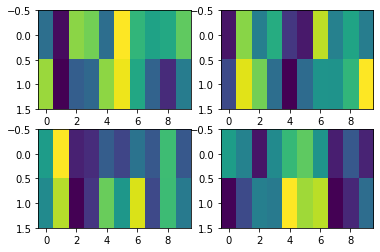

In [80]:
fig,ax = visualize.gen_square_subplots(mean_vals.shape[0])
for this_dat, this_ax in zip(mean_vals, ax.flatten()):
    this_ax.imshow(this_dat,aspect='auto')

In [81]:
 with pm.Model() as model:

        # Hierarchical firing rates
        # Refer to model diagram
        # Mean firing rate of neuron AT ALL TIMES
        lambda_nrn = pm.Exponential('lambda_nrn',
                                    1/mean_nrn_vals, 
                                    shape = (mean_vals.shape[-1]))
        # Priors for each state, derived from each neuron
        # Mean firing rate of neuron IN EACH STATE (averaged across tastes)
        lambda_state = pm.Exponential('lambda_state',
                                        lambda_nrn, 
                                        shape = (mean_vals.shape[1:]))
        # Mean firing rate of neuron PER STATE PER TASTE
        lambda_latent = pm.Exponential('lambda', 
                                        lambda_state[np.newaxis,:,:], 
                                        testval = mean_vals, 
                                        shape = (mean_vals.shape))

        # Changepoint time variable
        # INDEPENDENT TAU FOR EVERY TRIAL
        a = pm.HalfNormal('a_tau', 3., shape = states - 1)
        b = pm.HalfNormal('b_tau', 3., shape = states - 1)

        # Stack produces states x trials --> That gets transposed 
        # to trials x states and gets sorted along states (axis=-1)
        # Sort should work the same way as the Ordered transform --> 
        # see rv_sort_test.ipynb
        tau_latent = pm.Beta('tau_latent', a, b, 
                               shape = (trial_num, states-1),
                               testval = \
                                       tt.tile(even_switches_normal[1:(states)],
                                           (array_idx.shape[0],1))).sort(axis=-1)
               
        tau = pm.Deterministic('tau', 
                idx.min() + (idx.max() - idx.min()) * tau_latent)

In [82]:
lambda_latent.tag.test_value.shape

(4, 2, 10)

In [83]:
tau.tag.test_value.shape

(80, 1)

In [84]:
with model:
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((tastes*trials,1,length//bin_width)),weight_stack],axis=1)
    inverse_stack = 1 - weight_stack[:,1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((tastes*trials,1,length//bin_width))],axis=1)
    weight_stack = weight_stack*inverse_stack
    weight_stack = tt.tile(weight_stack[:,:,None,:], (1,1,nrns,1))
    
    lambda_latent = lambda_latent.dimshuffle(2,0,1)
    lambda_latent = tt.repeat(lambda_latent, trials, axis=1)
    lambda_latent = tt.tile(lambda_latent[...,None], (1,1,1,length//bin_width))
    lambda_latent = lambda_latent.dimshuffle(1,2,0,3)
    lambda_ = tt.sum(lambda_latent * weight_stack, axis=1)

In [85]:
weight_stack.tag.test_value.shape

(80, 2, 10, 100)

In [86]:
lambda_latent.tag.test_value.shape

(80, 2, 10, 100)

In [87]:
lambda_.tag.test_value.shape

(80, 10, 100)

In [88]:
data_array_long.shape

(80, 10, 1000)

In [89]:
# plt.imshow(weight_stack.tag.test_value[0,:,0],aspect='auto');

In [90]:
# print(f'lambda_latent : {lambda_latent.tag.test_value.shape}')
# print(f'weight_stack : {weight_stack.tag.test_value.shape}') # Positions of changepoint
# #print(f'lambda_latent[taste_labels] : {lambda_latent.tag.test_value[taste_labels].shape}')

In [91]:
# lambda_latent_test = lambda_latent.tag.test_value.copy()
# #lambda_latent_test = np.tile(lambda_latent_test, (1,2,1))
# lambda_latent_test = np.repeat(lambda_latent_test, trials, axis=1)
# lambda_latent_test = np.moveaxis(lambda_latent_test, 0, -1)
# lambda_latent_test.shape

In [92]:
# lambda_latent_test = np.tile(lambda_latent_test[...,None], (1,1,1,length))
# lambda_latent_test.shape

In [93]:
# weight_stack_test = weight_stack.tag.test_value
# weight_stack_test = np.tile(weight_stack_test[:,:,None], (1,1,nrns,1))
# weight_stack_test.shape

In [94]:
# plt.imshow(lambda_latent_test[...,1,0,:],aspect='auto', interpolation='nearest');

In [95]:
# lambda_ = np.sum(lambda_latent_test * weight_stack_test, axis=1)

In [96]:
# print(data_array_long.shape)

/media/bigdata/firing_space_plot/ephys_data/visualize.py:86: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  vmin = min_val[nrn], vmax = max_val[nrn])


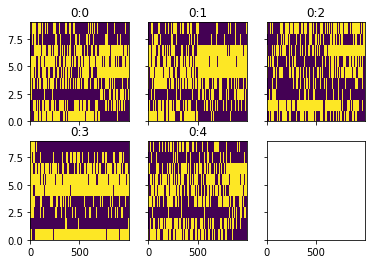

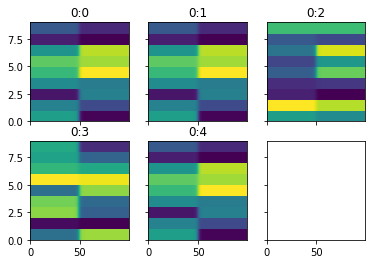

In [97]:
visualize.firing_overview(data_array_long[trial_inds],cmap='viridis');
visualize.firing_overview(lambda_.tag.test_value[trial_inds], cmap='viridis');

In [98]:
with model:
    # Add observations
    observation = pm.Poisson("obs", lambda_, observed=spike_array_long)

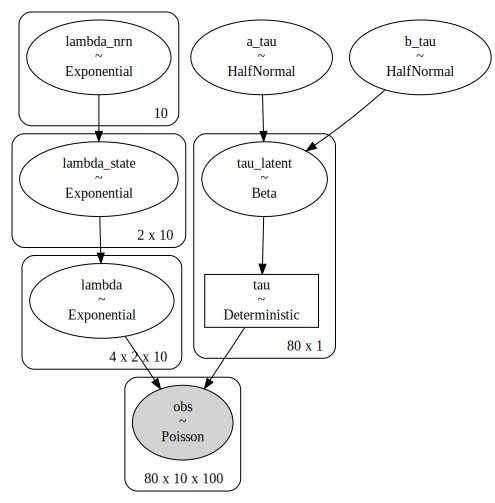

In [99]:
pm.model_to_graphviz(model)

In [ ]:
with model:
    approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
    trace = approx.sample(draws=samples)
    #trace = pm.sample()


In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(-approx.hist, alpha=.3)
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('iteration');

ind = int(fit - fit*0.05)
ax[1].plot(-approx.hist[ind:], alpha=.3)
ax[1].set_title('Final 5% of iterations')
ax[1].set_ylabel('ELBO')
ax[1].set_xlabel('iteration');

In [ ]:
ppc = pm.sample_posterior_predictive(trace, samples = 2000, model = model)

In [ ]:
trial_count = 7
trial_inds = np.random.choice(np.arange(trials),5)

In [ ]:
visualize.firing_overview(np.concatenate(true_r,axis=0)[trial_inds],cmap='viridis');
visualize.firing_overview(np.mean(ppc['obs'],axis=0)[trial_inds],cmap='viridis');

In [ ]:
#min_val,max_val = min(true_r),max(true_r)
tau = trace['tau']
print(tau.shape)
mode_tau = stats.mode(np.vectorize(np.int)(tau),axis=0)[0][0]
print(mode_tau.shape)

In [ ]:
fig,ax = plt.subplots(3,trial_count,sharex=True,figsize=(20,10))
for trial_num,this_trial_ind in enumerate(trial_inds):
    ax[0,trial_num].imshow(np.concatenate(true_r,axis=0)[this_trial_ind][...,::bin_width],aspect='auto', interpolation='nearest')
    ax[1,trial_num].imshow(spike_array_long[this_trial_ind],aspect='auto', interpolation='nearest')
    
    for tau_num, this_tau in enumerate(tau[:,this_trial_ind].T):
        ax[2,trial_num].hist(this_tau,bins=50)
        ax[0,trial_num].vlines(mode_tau[this_trial_ind,tau_num],-0.5,nrns-0.5,color='red',alpha=1,linewidth=5, linestyles='dashed')